In [ ]:
### [Step 0] Colab 드라이브 마운트 + JSON/ZIP 원천데이터 로딩 유틸(이번 분석에서는 직접 사용 안 함, 참고용)

# 0) 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

# 1) 정확한 경로(대소문자 주의!)
BASE = "/content/drive/MyDrive/파이썬머신러닝2/Sample"   # <-- S 대문자!
SRC_DIR = f"{BASE}/01.원천데이터"
LBL_DIR = f"{BASE}/02.라벨링데이터"   # 이 아래에 과별 하위 폴더가 있어도 OK (재귀 탐색)

# 2) 폴더 트리 확인(경로가 맞는지 먼저 눈으로 확인)
import os
def list_tree(root, depth=2):
    print(f"[TREE] {root}")
    for cur, dirs, files in os.walk(root):
        d = cur[len(root):].count(os.sep)
        if d > depth:
            continue
        indent = "  " * d
        print(f"{indent}- {os.path.basename(cur) or cur}")
        for f in files[:20]:
            print(f"{indent}    · {f}")
list_tree(BASE, depth=3)
print("EXISTS SRC_DIR:", os.path.exists(SRC_DIR))
print("EXISTS LBL_DIR:", os.path.exists(LBL_DIR))

# 3) 재귀로 모든 .json/.jsonl(.gz/.zip 포함) 읽기
import glob, json, gzip, zipfile
import pandas as pd

def collect_files(dir_path):
    files = glob.glob(os.path.join(dir_path, "**", "*"), recursive=True)
    out = []
    for fp in files:
        if os.path.isdir(fp):
            continue
        low = fp.lower()
        if low.endswith((".json",".jsonl",".json.gz",".jsonl.gz",".zip")):
            out.append(fp)
    return out

def read_json_any(fp):
    low = fp.lower()

    def read_stream(fobj):
        # jsonl 우선, 실패하면 일반 json
        try:
            return pd.read_json(fobj, lines=True)
        except Exception:
            fobj.seek(0)
            data = json.load(fobj)
            return pd.json_normalize(data)

    if low.endswith((".json",".jsonl")):
        for enc in ("utf-8","cp949","euc-kr"):
            try:
                with open(fp, "r", encoding=enc) as f:
                    return read_stream(f)
            except Exception:
                continue
        print("인코딩 실패:", fp); return pd.DataFrame()

    if low.endswith((".json.gz",".jsonl.gz")):
        for enc in ("utf-8","cp949","euc-kr"):
            try:
                with gzip.open(fp, "rt", encoding=enc) as f:
                    return read_stream(f)
            except Exception:
                continue
        print("gz 인코딩 실패:", fp); return pd.DataFrame()

    if low.endswith(".zip"):
        rows = []
        with zipfile.ZipFile(fp) as z:
            for name in z.namelist():
                if name.lower().endswith((".json",".jsonl")):
                    for enc in ("utf-8","cp949","euc-kr"):
                        try:
                            txt = z.read(name).decode(enc)
                            try:
                                df = pd.read_json(pd.io.common.StringIO(txt), lines=True)
                            except Exception:
                                obj = json.loads(txt)
                                df = pd.json_normalize(obj)
                            df["__zip_entry__"] = name
                            rows.append(df)
                            break
                        except Exception:
                            continue
        return pd.concat(rows, ignore_index=True) if rows else pd.DataFrame()

    return pd.DataFrame()

def load_dir(dir_path):
    files = collect_files(dir_path)
    print(f"[{os.path.basename(dir_path)}] 후보 파일:", len(files))
    print("\n".join(["  - "+os.path.basename(f) for f in files[:10]]))
    dfs = []
    for fp in files:
        try:
            df = read_json_any(fp)
            if len(df):
                df["__file__"] = os.path.basename(fp)
                dfs.append(df)
        except Exception as e:
            print("skip:", fp, "->", e)
    return pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()

src_df = load_dir(SRC_DIR)
lbl_df = load_dir(LBL_DIR)

print("원천 shape:", src_df.shape)
print("라벨 shape:", lbl_df.shape)

from IPython.display import display
if len(src_df): display(src_df.head(3))
if len(lbl_df): display(lbl_df.head(3))

# 4) 표준 컬럼으로 간단 정규화(질문/답변/근거)
def normalize_df(df):
    def pick(*names):
        for n in names:
            if n in df.columns: return n
        return None
    q = pick("question","질문","query","Question","질의")
    a = pick("answer","답변","정답","Answer")
    e = pick("evidence","passage","context","근거","본문")
    out = pd.DataFrame()
    out["question"] = df[q] if q else None
    out["answer"]   = df[a] if a else None
    out["evidence"] = df[e] if e else None
    return out

if len(src_df):
    norm = normalize_df(src_df)
    print("정규화 미리보기:")
    display(norm.head(5))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[TREE] /content/drive/MyDrive/파이썬머신러닝2/Sample
- Sample
  - 01.원천데이터
      · cid_59722_1.json
      · cid_59717_1.json
      · cid_59723_1.json
      · cid_59710_1.json
      · cid_59721_1.json
      · cid_59712_1.json
      · cid_59709_1.json
      · cid_59718_1.json
      · cid_59716_1.json
      · cid_59711_1.json
      · cid_59724_1.json
      · cid_59725_1.json
      · cid_59715_1.json
      · cid_59719_1.json
      · cid_59714_1.json
      · cid_59730_1.json
      · cid_59713_1.json
      · cid_59726_1.json
      · cid_59728_1.json
      · cid_59729_1.json
  - 02.라벨링데이터
    - 이비인후과
        · 전문_618721.json
        · 전문_626379.json
    - 신경과신경외과
        · 전문_610922.json
        · 전문_5754.json
        · 전문_5602.json
        · 전문_625873.json
        · 전문_613323.json
        · 전문_616707.json
   

KeyboardInterrupt: 

In [ ]:
## [Step 1] 전처리 완료된 원천데이터 long_df_v1.xlsx 로드 (Kaggle Prescription-based Prediction 서브셋)


from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

file_path = "/content/drive/MyDrive/파이썬머신러닝2/long_df_v1.xlsx"
long_df = pd.read_excel(file_path)

long_df.head()


In [ ]:
## [Step 2] 기본 EDA: 수치형·범주형 변수 설정 및 분포 시각화(히스토그램/기본 통계용 준비)

# =============================================
# 📘 0. 라이브러리 임포트
# =============================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['figure.figsize'] = (10, 5)

# =============================================
# 📘 1. 수치형 / 범주형 변수 구분
# =============================================
numeric_cols = ['years_practicing', 'brand_name_rx_count', 'generic_rx_count', 'rx_count']
categorical_cols = ['specialty', 'region', 'gender', 'settlement_type', 'TA']

# =============================================
# 📘 2. 수치형 변수 EDA (히스토그램 + KDE + 비중 라벨)
# =============================================
for col in numeric_cols:
    plt.figure(figsize=(8,4))
    ax = sns.histplot(data=long_df, x=col, kde=True, bins=30, color='skyblue')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')

    total = len(long_df[col].dropna())  # 전체 관측치
    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            pct = (height / total) * 100
            ax.text(p.get_x() + p.get_width()/2,
                    height + 0.5,
                    f"{int(height)} ({pct:.1f}%)",
                    ha='center', va='bottom', fontsize=8)
    plt.tight_layout()
    plt.show()

# =============================================
# 📘 3. 범주형 변수 EDA (카운트플롯 + 비중 라벨)
# =============================================
for col in categorical_cols:
    plt.figure(figsize=(8,4))
    order = long_df[col].value_counts().index[:10]  # 상위 10개만 표시
    ax = sns.countplot(data=long_df, x=col, order=order, palette='pastel')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')

    total = len(long_df[col].dropna())
    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            pct = (height / total) * 100
            ax.text(p.get_x() + p.get_width()/2,
                    height + 0.02*max(long_df[col].value_counts().values),
                    f"{int(height)} ({pct:.1f}%)",
                    ha='center', va='bottom', fontsize=8)
    plt.tight_layout()
    plt.show()

# =============================================
# 📘 4. 브랜드 처방 비율 (brand_ratio + 비중 라벨)
# =============================================
long_df['brand_ratio'] = (
    long_df['brand_name_rx_count'] /
    (long_df['brand_name_rx_count'] + long_df['generic_rx_count'] + 1e-6)
)

plt.figure(figsize=(7,4))
ax = sns.histplot(data=long_df, x='brand_ratio', kde=True, color='coral', bins=30)
plt.title('Distribution of Brand Prescription Ratio')
plt.xlabel('Brand Rx Ratio')
plt.ylabel('Count')

total = len(long_df['brand_ratio'].dropna())
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        pct = (height / total) * 100
        ax.text(p.get_x() + p.get_width()/2,
                height + 0.5,
                f"{int(height)} ({pct:.1f}%)",
                ha='center', va='bottom', fontsize=8)
plt.tight_layout()
plt.show()

# =============================================
# 📘 5. TA별 평균 Rx Count (상위 10개 + 라벨)
# =============================================
ta_summary = (
    long_df.groupby('TA')['rx_count']
    .mean()
    .sort_values(ascending=False)
    .head(10)
    .reset_index()
)

plt.figure(figsize=(8,4))
ax = sns.barplot(data=ta_summary, x='TA', y='rx_count', palette='cool')
plt.title('Average Rx Count by TA (Top 10)')
plt.xlabel('Therapeutic Area')
plt.ylabel('Average Rx Count')
plt.xticks(rotation=45, ha='right')

for i, v in enumerate(ta_summary['rx_count']):
    ax.text(i, v + 0.5, f"{v:.1f}", ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()



In [ ]:
# [Step 2-1] TA별 처방 분포(Boxplot) + Top 30 Provider × Top 15 TA 히트맵 시각화

import seaborn as sns
import matplotlib.pyplot as plt

# === 1️⃣ Boxplot: TA별 처방 분포 (가로형 + 샘플 수 필터링) ===
plt.figure(figsize=(12,8))

# 평균 처방량이 너무 적은 TA는 제외 (노이즈 제거)
ta_mean = long_df.groupby('TA')['rx_count'].mean().sort_values(ascending=False)
ta_keep = ta_mean[ta_mean > 1].index   # 평균 1건 이상만 표시

sns.boxplot(
    y='TA', x='rx_count',
    data=long_df[long_df['TA'].isin(ta_keep)],
    orient='h',  # 가로형
    fliersize=1  # 이상치 점 작게
)
plt.xscale('log')
plt.title("Distribution of Prescription Counts by Therapeutic Area (Filtered)")
plt.xlabel("Prescription Count (log scale)")
plt.ylabel("Therapeutic Area (TA)")
plt.tight_layout()
plt.show()


# === 2️⃣ Heatmap: Provider × TA (가독성 개선) ===

# 1. TA 비율 매트릭스 (위에서 만든 ta_ratio 재활용)
ta_matrix = (
    long_df.pivot_table(
        index='npi',
        columns='TA',
        values='rx_count',
        aggfunc='sum',
        fill_value=0
    )
)
ta_ratio = ta_matrix.div(ta_matrix.sum(axis=1), axis=0).fillna(0)

# 2. 상위 provider + 주요 TA만 추출 (너무 많으면 희미함)
top_npi = ta_matrix.sum(axis=1).nlargest(30).index
top_ta = ta_matrix.sum(axis=0).nlargest(15).index

ta_ratio_sub = ta_ratio.loc[top_npi, top_ta]

# 3. 히트맵 (정렬 + 커서블 루컬러)
plt.figure(figsize=(10,6))
sns.heatmap(
    ta_ratio_sub,
    cmap="Blues",
    linewidths=0.3,
    linecolor='gray',
    cbar_kws={'label':'TA Prescription Ratio'},
)
plt.title("Top 30 Providers × Top 15 Therapeutic Areas")
plt.xlabel("Therapeutic Area (TA)")
plt.ylabel("Provider (NPI)")
plt.tight_layout()
plt.show()


   Silhouette       DBI
k                      
2    0.276901  1.286123
3    0.185210  1.710786
4    0.238899  1.889933
5    0.249604  1.985217
6    0.263451  1.803153

[선택] k=6 (비즈니스/해석 목적 상 6개로 고정)
최종 Silhouette (k=6) = 0.263


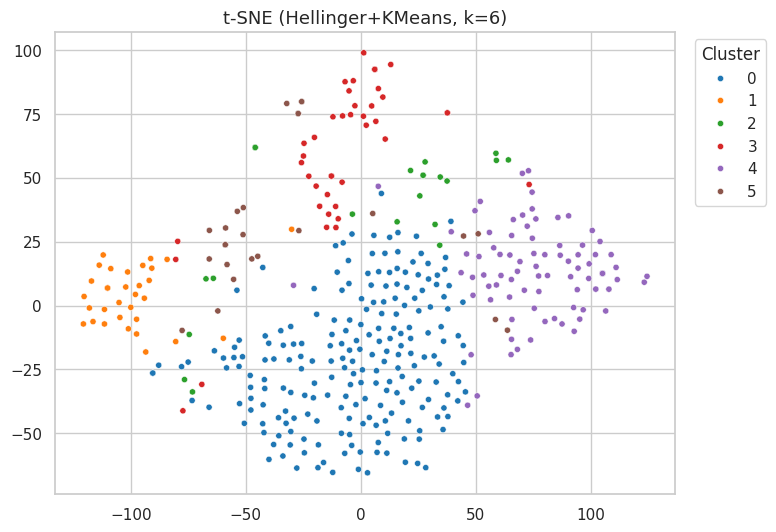

In [ ]:
## [Step 3] TA 비율 기반 군집 분석: 상위 15개 TA + OTHER, Hellinger 변환 후 KMeans(k=6) + t-SNE 시각화

from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import numpy as np
import pandas as pd

# --- 1) 상위 15개 TA만 남기기 ---
top_tas = long_df['TA'].value_counts().head(15).index
ta_top = long_df[long_df['TA'].isin(top_tas)]

ta_pivot = ta_top.pivot_table(
    index='npi',
    columns='TA',
    values='rx_count',
    aggfunc='sum',
    fill_value=0
)

# OTHER 컬럼 추가 (전체 - 상위15)
ta_pivot['OTHER'] = long_df.groupby('npi')['rx_count'].sum() - ta_pivot.sum(axis=1)

# 각 NPI별 비율로 변환
ta_pivot = ta_pivot.div(ta_pivot.sum(axis=1), axis=0)

# --- 2) Hellinger 변환 ---
ta_hell = np.sqrt(ta_pivot)

# --- 3) 정규화 후 K-Means ---
ta_norm = normalize(ta_hell)  # 각 행 벡터 단위화

# (선택) k=2~6 성능 비교는 참고용
k_range = range(2, 7)
metrics = []
for k in k_range:
    km_tmp = KMeans(n_clusters=k, random_state=42)
    labels_tmp = km_tmp.fit_predict(ta_norm)
    sil = silhouette_score(ta_norm, labels_tmp, metric='euclidean')
    dbi = davies_bouldin_score(ta_norm, labels_tmp)
    metrics.append((k, sil, dbi))

metrics_df = pd.DataFrame(metrics, columns=['k','Silhouette','DBI']).set_index('k')
print(metrics_df)

# --- 4) 최종 k는 비즈니스 관점에서 6개로 고정 ---
best_k = 6
print(f"\n[선택] k={best_k} (비즈니스/해석 목적 상 6개로 고정)")

# --- 5) 최종 클러스터링 ---
km = KMeans(n_clusters=best_k, random_state=42)
labels = km.fit_predict(ta_norm)
sil_final = silhouette_score(ta_norm, labels)
print(f"최종 Silhouette (k={best_k}) = {sil_final:.3f}")

# --- 6) t-SNE로 시각화 ---
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
emb = tsne.fit_transform(ta_norm)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=emb[:, 0], y=emb[:, 1], hue=labels, palette='tab10', s=20)
plt.title(f"t-SNE (Hellinger+KMeans, k={best_k})")
plt.legend(title='Cluster', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.show()


In [11]:
# [Step 4] provider 레벨 요약 + cluster 라벨 병합 → provider_cluster 생성 및 군집별 기본 프로필(연속/범주형) 요약

# ==========================================================
# 통합 파이프라인
# 전제:
#   - long_df: 아래 provider_cols 보유 (long format)
#   - ta_pivot: index=npi, columns=TA, 값=비율(행합=1)  # 군집 입력에 사용
#   - labels: KMeans 결과 라벨 (len(labels) == len(ta_pivot))
# ==========================================================
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multitest import multipletests

# -----------------------------
# 0) 입력 스펙
# -----------------------------
provider_cols = [
    'npi', 'specialty', 'region', 'years_practicing', 'gender',
    'settlement_type', 'brand_name_rx_count', 'generic_rx_count'
]
continuous_vars = ['years_practicing', 'brand_name_rx_count', 'generic_rx_count']
categorical_vars = ['specialty', 'region', 'gender', 'settlement_type']

# -----------------------------
# 1) cluster_df 생성 (npi, cluster)
# -----------------------------
assert len(ta_pivot.index) == len(labels), "[Error] ta_pivot.index와 labels 길이가 다름"

cluster_df = pd.DataFrame({
    'npi': ta_pivot.index.astype(str),
    'cluster': labels
})
cluster_df['npi'] = cluster_df['npi'].astype(str).str.strip()
cluster_df['cluster'] = pd.to_numeric(cluster_df['cluster'], errors='coerce')

print("[Info] cluster_df 미리보기")
print(cluster_df.head(), "\n")

# -----------------------------
# 2) provider_df 생성 (npi 레벨 1행)
# -----------------------------
_missing = [c for c in provider_cols if c not in long_df.columns]
if _missing:
    raise KeyError(f"[Error] long_df에 다음 열이 없습니다: {_missing}")

tmp = long_df.copy()
tmp['npi'] = tmp['npi'].astype(str).str.strip()

agg_map = {
    'specialty': 'first',
    'region': 'first',
    'years_practicing': 'first',
    'gender': 'first',
    'settlement_type': 'first',
    # Rx 카운트는 provider 레벨 종합 지표 → 데이터 생성 로직에 맞게 'max'/'sum' 중 선택
    'brand_name_rx_count': 'max',
    'generic_rx_count': 'max'
}
provider_df = tmp.groupby('npi', as_index=False).agg(agg_map)
print("[Info] provider_df shape:", provider_df.shape)

# -----------------------------
# 3) 병합: provider_cluster
# -----------------------------
provider_cluster = provider_df.merge(cluster_df, on='npi', how='inner')
provider_cluster['cluster'] = pd.to_numeric(provider_cluster['cluster'], errors='coerce')

# 타입 캐스팅
for c in continuous_vars:
    if c in provider_cluster.columns:
        provider_cluster[c] = pd.to_numeric(provider_cluster[c], errors='coerce')
for c in categorical_vars:
    if c in provider_cluster.columns:
        provider_cluster[c] = provider_cluster[c].astype('category')

print("[Info] provider_cluster shape:", provider_cluster.shape)
print("[Info] 클러스터 분포\n", provider_cluster['cluster'].value_counts().sort_index(), "\n")

# ==========================================================
# 4) 요약표들
# ==========================================================
# 4-1) 연속형 상세 요약(Count/Mean/Std/Median/Q1/Q3/Min/Max)
def summarize_continuous_by_cluster(df, cols, cluster_col='cluster'):
    out = {}
    for col in cols:
        if col not in df.columns:
            continue
        g = df.groupby(cluster_col)[col]
        desc = pd.DataFrame({
            'count': g.count(),
            'mean': g.mean(),
            'std': g.std(),
            'median': g.median(),
            'q1': g.quantile(0.25),
            'q3': g.quantile(0.75),
            'min': g.min(),
            'max': g.max()
        }).round(2)
        out[col] = desc
    return out

cont_summaries = summarize_continuous_by_cluster(provider_cluster, continuous_vars)

# 4-2) 연속형 mean만 모은 테이블
table_cont_means = (
    provider_cluster
    .groupby('cluster')[continuous_vars]
    .mean()
    .round(2)
)

# 4-3) 범주형: 교차표(건수) + 클러스터 열 기준 비율(%) + 보기좋게 병합
def crosstab_with_percent(df, cat_col, cluster_col='cluster', percent='col'):
    ct = pd.crosstab(df[cat_col], df[cluster_col], dropna=False)
    if percent == 'col':
        pct = (ct / ct.sum(axis=0)).fillna(0) * 100
    else:
        pct = (ct.div(ct.sum(axis=1), axis=0)).fillna(0) * 100
    pretty = ct.astype(int).astype(str) + " (" + pct.round(1).astype(str) + "%)"
    return ct, pct.round(1), pretty

cat_tables = {}
for var in categorical_vars:
    if var not in provider_cluster.columns:
        continue
    ct_count, ct_pct, ct_pretty = crosstab_with_percent(provider_cluster, var, percent='col')
    cat_tables[var] = {'counts': ct_count, 'percent_by_cluster': ct_pct, 'pretty': ct_pretty}

# 4-4) 범주형 top1(%) 요약 테이블
top_cat_rows = []
for var in categorical_vars:
    if var not in provider_cluster.columns:
        continue
    ct = pd.crosstab(provider_cluster[var], provider_cluster['cluster'])
    pct = (ct / ct.sum(axis=0)).fillna(0) * 100
    row = []
    for c in pct.columns:
        top_label = pct[c].idxmax()
        top_val = pct[c].max()
        row.append(f"{top_label} ({top_val:.1f}%)")
    top_cat_rows.append(pd.Series(row, index=pct.columns, name=var))
table_cat_top = pd.DataFrame(top_cat_rows)

print("========== [연속형 mean 요약] ==========")
print(table_cont_means, "\n")

print("========== [범주형 top1(%) 요약] ==========")
print(table_cat_top, "\n")

# (옵션) 군집별 TA 평균 프로필(해석에 매우 유용)
#  - npi 충돌 방지: reset_index(names='npi')로 안전하게 변환
ta_profile_by_cluster = None
try:
    ta_profile_by_cluster = (
        ta_pivot
        .reset_index(names='npi')           # <- 핵심: index→컬럼, 이름 명시
        .merge(cluster_df, on='npi', how='inner')
        .drop(columns=['npi'])
        .groupby('cluster')
        .mean()
        .round(3)
    )
    print("========== [클러스터별 TA 평균 비중] ==========")
    print(ta_profile_by_cluster)
except Exception as e:
    print("[Warn] TA 평균 프로필 생성 실패:", e)

# 4-5) 군집별 Top3 TA 출력 (평균 비중 기준) -----------------------------
#  - ta_profile_by_cluster가 있으면 그걸로, 없으면 long_df에서 다시 생성
def top3_ta_from_profile(profile_df, top_k=3):
    """
    profile_df: index=cluster, columns=TA, values=mean proportion (0~1 or 0~100)
    return: DataFrame [cluster × 'Top3_TA'] with formatted strings
    """
    def fmt_topn(row):
        # row: Series of TA proportions
        s = row.sort_values(ascending=False).head(top_k)
        # 비율 스케일(0~1 or 0~100)에 따라 % 포맷 맞춤
        scale = 100.0 if s.max() <= 1.0 else 1.0
        items = [f"{ta} ({(val*scale):.1f}%)" for ta, val in s.items()]
        return " / ".join(items)

    return pd.DataFrame({
        'Top3_TA': profile_df.apply(fmt_topn, axis=1)
    })

try:
    if ta_profile_by_cluster is None:
        # long_df에서 직접 생성 (npi × TA 비중피벗 → cluster 평균)
        # long_df에 npi, TA, rx_count가 있다고 가정
        _tmp = (
            long_df[long_df['rx_count'] > 0]
            .groupby(['npi','TA'])['rx_count'].sum().reset_index()
        )
        _tot = _tmp.groupby('npi')['rx_count'].sum().rename('tot')
        _tmp = _tmp.merge(_tot, on='npi', how='left')
        _tmp['prop'] = _tmp['rx_count'] / _tmp['tot']
        ta_pivot2 = _tmp.pivot_table(index='npi', columns='TA', values='prop', fill_value=0.0)
        ta_profile_by_cluster = (
            ta_pivot2
            .reset_index(names='npi')
            .merge(cluster_df, on='npi', how='inner')
            .drop(columns=['npi'])
            .groupby('cluster')
            .mean()
            .round(3)
        )

    table_ta_top3 = top3_ta_from_profile(ta_profile_by_cluster, top_k=3)
    print("========== [군집별 Top3 TA (평균 비중 기준)] ==========")
    print(table_ta_top3, "\n")
except Exception as e:
    print("[Warn] Top3 TA 생성 실패:", e)


# ==========================================================
# 5) 통계검정
#    - 연속형: Levene(등분산성) + ANOVA + Tukey HSD(사후)
#    - 범주형: 전체 카이제곱 + (유의시) 클러스터 쌍별 카이제곱 + Holm 보정
# ==========================================================

# 5-1) 연속형: ANOVA & Levene & Tukey
anova_rows = []
tukey_results = {}  # 변수별 Tukey 표 저장

for col in continuous_vars:
    if col not in provider_cluster.columns:
        continue

    sub = provider_cluster[['cluster', col]].dropna()
    if sub['cluster'].nunique() < 2:
        print(f"[Skip] {col}: 유효 클러스터 < 2")
        continue

    # 그룹별 배열 (각 그룹 표본≥2만 포함)
    groups = [g[col].values for _, g in sub.groupby('cluster') if g[col].notna().sum() >= 2]
    if len(groups) < 2:
        print(f"[Skip] {col}: 각 그룹 표본 부족")
        continue

    # Levene
    lev_stat, lev_p = stats.levene(*groups, center='median')

    # ANOVA
    f_stat, p_val = stats.f_oneway(*groups)

    anova_rows.append({
        'variable': col,
        'F': f_stat,
        'p': p_val,
        'Levene_stat': lev_stat,
        'Levene_p': lev_p,
        'EqualVariance? (Levene_p>=0.05)': lev_p >= 0.05
    })
    print(f"[ANOVA] {col}: F={f_stat:.4f}, p={p_val:.4g} | Levene p={lev_p:.4g}")

    # Tukey HSD (사후검정)
    try:
        tk = pairwise_tukeyhsd(endog=sub[col].values,
                               groups=sub['cluster'].astype(str).values,
                               alpha=0.05)
        tukey_df = pd.DataFrame(tk.summary().data[1:], columns=tk.summary().data[0])
        tukey_results[col] = tukey_df
        print(f"[Tukey HSD] {col}")
        print(tukey_df)
    except Exception as e:
        print(f"[Tukey HSD 실패] {col}: {e}")

anova_summary = pd.DataFrame(anova_rows).sort_values('p') if anova_rows else pd.DataFrame()
print("\n[ANOVA 요약]")
print(anova_summary, "\n")

# 5-2) 범주형: 전체 카이제곱 + 쌍별 카이제곱(2×K) + Holm 보정
def pairwise_chi2_posthoc(df, var, cluster_col='cluster', alpha=0.05, method='holm'):
    """
    클러스터 쌍별(2×K) 카이제곱 수행 후 다중비교 보정.
    반환: 쌍, p_raw, p_adj 컬럼의 DataFrame
    """
    from itertools import combinations
    clusters = sorted(df[cluster_col].dropna().unique().tolist())
    pairs = list(combinations(clusters, 2))

    raw_p = []
    labels = []
    for c1, c2 in pairs:
        sub = df[df[cluster_col].isin([c1, c2])]
        tab = pd.crosstab(sub[var], sub[cluster_col])
        if tab.shape[0] >= 2 and tab.shape[1] == 2:
            chi2, p, dof, ex = stats.chi2_contingency(tab)
            raw_p.append(p)
            labels.append(f"{c1} vs {c2}")
        else:
            raw_p.append(np.nan)
            labels.append(f"{c1} vs {c2}")

    p_adj = [np.nan]*len(raw_p)
    valid = [i for i, v in enumerate(raw_p) if pd.notna(v)]
    if valid:
        rej, pvals_adj, _, _ = multipletests([raw_p[i] for i in valid], alpha=alpha, method=method)
        for j, i in enumerate(valid):
            p_adj[i] = pvals_adj[j]

    return pd.DataFrame({'pair': labels, 'p_raw': raw_p, f'p_adj_{method}': p_adj})

chi_rows = []
chi_posthoc = {}  # 변수별 쌍별검정 결과 저장

for var in categorical_vars:
    if var not in provider_cluster.columns:
        continue

    sub = provider_cluster[['cluster', var]].dropna()
    if sub['cluster'].nunique() < 2:
        print(f"[Skip] {var}: 유효 클러스터 < 2")
        continue

    ct = pd.crosstab(sub[var], sub['cluster'])
    if ct.shape[0] < 2 or ct.shape[1] < 2:
        print(f"[Skip] {var}: 교차표 차원 부족 -> {ct.shape}")
        continue

    chi2, p, dof, expected = stats.chi2_contingency(ct)
    chi_rows.append({'variable': var, 'chi2': chi2, 'dof': dof, 'p': p, 'n_levels': ct.shape[0]})
    print(f"[Chi-square] {var}: chi2={chi2:.4f}, dof={dof}, p={p:.4g}")

    # 유의하면 쌍별 사후검정
    if p < 0.05:
        try:
            post = pairwise_chi2_posthoc(sub, var, cluster_col='cluster', alpha=0.05, method='holm')
            chi_posthoc[var] = post.sort_values(f'p_adj_holm')
            print(f"[Pairwise post-hoc: Holm] {var}")
            print(chi_posthoc[var])
        except Exception as e:
            print(f"[Post-hoc 실패] {var}: {e}")

chi_summary = pd.DataFrame(chi_rows).sort_values('p') if chi_rows else pd.DataFrame()
print("\n[Chi-square 요약]")
print(chi_summary)

# ==========================================================
# 6) (옵션) 엑셀 저장 — 주석 해제 시 파일로 저장
# ==========================================================
# with pd.ExcelWriter("cluster_provider_profiles_full.xlsx", engine="xlsxwriter") as xw:
#     provider_cluster.to_excel(xw, sheet_name="provider_cluster_raw", index=False)
#     # 연속형
#     table_cont_means.to_excel(xw, sheet_name="continuous_means")
#     for k, v in cont_summaries.items():
#         v.to_excel(xw, sheet_name=f"cont_{k}")
#     # 범주형
#     for var, tabs in cat_tables.items():
#         tabs['counts'].to_excel(xw, sheet_name=f"{var}_counts")
#         tabs['percent_by_cluster'].to_excel(xw, sheet_name=f"{var}_pct")
#         tabs['pretty'].to_excel(xw, sheet_name=f"{var}_pretty")
#     table_cat_top.to_excel(xw, sheet_name="categorical_top1")
#     # 통계 요약
#     anova_summary.to_excel(xw, sheet_name="anova_summary", index=False)
#     for var, df_ in tukey_results.items():
#         df_.to_excel(xw, sheet_name=f"tukey_{var}", index=False)
#     chi_summary.to_excel(xw, sheet_name="chisq_summary", index=False)
#     for var, df_ in chi_posthoc.items():
#         df_.to_excel(xw, sheet_name=f"chisq_posthoc_{var}", index=False)
# print("[Saved] cluster_provider_profiles_full.xlsx")


[Info] cluster_df 미리보기
          npi  cluster
0  1003801283        3
1  1003841289        0
2  1003861477        1
3  1003870171        0
4  1003980947        4 

[Info] provider_df shape: (457, 8)
[Info] provider_cluster shape: (453, 9)
[Info] 클러스터 분포
 cluster
0    213
1     43
2     25
3     52
4     88
5     32
Name: count, dtype: int64 

========== [연속형 mean 요약] ==========
         years_practicing  brand_name_rx_count  generic_rx_count
cluster                                                         
0                    6.90                66.05            441.89
1                    6.88                57.95            391.12
2                    7.08                41.48            369.48
3                    7.12               111.79            775.52
4                    7.01                60.24            457.15
5                    6.97                87.78            507.50 

========== [범주형 top1(%) 요약] ==========
cluster                                      0             

In [12]:
# [Step 4-1] 군집별 TA 평균 비중 테이블 및 군집별 Top3 TA(평균 비중 기준) 추출

# ============================
# TA 프로필 및 Top3 TA 생성 (dtype mismatch fix)
# ============================

try:
    # 두 테이블 npi 타입을 일관되게 문자로 변환
    cluster_df['npi'] = cluster_df['npi'].astype(str).str.strip()
    ta_pivot = ta_pivot.copy()
    ta_pivot.index = ta_pivot.index.astype(str)

    ta_profile_by_cluster = (
        ta_pivot
        .reset_index(names='npi')
        .merge(cluster_df, on='npi', how='inner')
        .drop(columns=['npi'])
        .groupby('cluster')
        .mean()
        .round(3)
    )
    print("========== [클러스터별 TA 평균 비중] ==========")
    print(ta_profile_by_cluster)
except Exception as e:
    print("[Warn] TA 평균 프로필 생성 실패:", e)


# -------------------------------
# 군집별 Top3 TA 생성 (평균 비중 기준)
# -------------------------------
def top3_ta_from_profile(profile_df, top_k=3):
    def fmt_topn(row):
        s = row.sort_values(ascending=False).head(top_k)
        scale = 100.0 if s.max() <= 1.0 else 1.0
        return " / ".join([f"{ta} ({(val*scale):.1f}%)" for ta, val in s.items()])
    return pd.DataFrame({'Top3_TA': profile_df.apply(fmt_topn, axis=1)})

try:
    if ta_profile_by_cluster is None:
        print("[Warn] ta_profile_by_cluster가 없음. long_df 기반 재계산 수행")
        # long_df 기반으로 생성
        long_df['npi'] = long_df['npi'].astype(str)
        _tmp = (
            long_df[long_df['rx_count'] > 0]
            .groupby(['npi','TA'])['rx_count'].sum().reset_index()
        )
        _tot = _tmp.groupby('npi')['rx_count'].sum().rename('tot')
        _tmp = _tmp.merge(_tot, on='npi', how='left')
        _tmp['prop'] = _tmp['rx_count'] / _tmp['tot']
        ta_pivot2 = _tmp.pivot_table(index='npi', columns='TA', values='prop', fill_value=0.0)
        ta_pivot2.index = ta_pivot2.index.astype(str)

        cluster_df['npi'] = cluster_df['npi'].astype(str)
        ta_profile_by_cluster = (
            ta_pivot2
            .reset_index(names='npi')
            .merge(cluster_df, on='npi', how='inner')
            .drop(columns=['npi'])
            .groupby('cluster')
            .mean()
            .round(3)
        )

    table_ta_top3 = top3_ta_from_profile(ta_profile_by_cluster, top_k=3)
    print("========== [군집별 Top3 TA (평균 비중 기준)] ==========")
    print(table_ta_top3, "\n")

except Exception as e:
    print("[Warn] Top3 TA 생성 실패:", e)


========== [클러스터별 TA 평균 비중] ==========
         ANAESTHETICS/PAIN  ANTI-INFECTIVES  ANTICOAGULANTS  CARDIOVASCULAR  \
cluster                                                                       
0                    0.052            0.027           0.028           0.056   
1                    0.007            0.004           0.000           0.008   
2                    0.009            0.381           0.000           0.024   
3                    0.330            0.008           0.087           0.224   
4                    0.064            0.012           0.027           0.022   
5                    0.008            0.004           0.038           0.010   

           CNS   DERM    ENT     GI  HORMONES  MUSCULOSKELETAL   ONCO  \
cluster                                                                 
0        0.076  0.129  0.076  0.104     0.063            0.008  0.180   
1        0.034  0.042  0.022  0.017     0.006            0.010  0.023   
2        0.208  0.057  0.006  0.047 

In [13]:
# [Step 5] ATC 코드 기반 ONCO Subcategory 매핑 + 군집별 ONCO 비중, ATC3/서브카테고리 비중, 상위 Molecule 요약

# ============================
# 0) 준비: 최소 컬럼만 사용
# ============================
import pandas as pd
import numpy as np

ldf = long_df.copy()
rename_map = {
    'ATC_code': 'atc_code', 'ATC_CODE': 'atc_code',
    'MOLECULE': 'Molecule', 'molecule': 'Molecule',
}
ldf.rename(columns={k:v for k,v in rename_map.items() if k in ldf.columns}, inplace=True)

need_cols = ['npi', 'atc_code', 'TA', 'type', 'DIV', 'Molecule', 'rx_count']
missing = [c for c in need_cols if c not in ldf.columns]
if missing:
    raise KeyError(f"[Error] long_df에 다음 열이 필요해: {missing}")

ldf['npi'] = ldf['npi'].astype(str).str.strip()
provider_cluster['npi'] = provider_cluster['npi'].astype(str).str.strip()

# ============================
# 1) provider_cluster에 노란 컬럼 조인
#    (처방 레벨로 확장: npi×drug 행)
# ============================
cols_yellow = ['npi','atc_code','TA','type','DIV','Molecule','rx_count']
pc_drug = (
    ldf[cols_yellow]
    .merge(provider_cluster[['npi','cluster']], on='npi', how='inner')
)
pc_drug = pc_drug[pc_drug['rx_count'] > 0].copy()

# ============================
# 2) ONCO MAP (서브카테고리 분류)
#    - 위에서부터 순서대로 매칭(elif) → 남는 L01~L04는 'Other oncology agents'
# ============================
def map_onco_subcategory(atc):
    if not isinstance(atc, str):
        return "Non-onco"
    a = atc.upper()

    # 1) Cytotoxic agents (전통적 세포독성)
    if a.startswith(("L01A","L01B","L01C","L01D","L01F")):
        return "Chemo therapy"

    # 2) Targeted therapy (표적치료: TKIs/기타 표적 포함)
    elif a.startswith(("L01E","L01X")):
        return "Targeted therapy"

    # 3) Hormonal therapy (호르몬/항호르몬)
    elif a.startswith(("L02A","L02B","L02E","L02G")):
        return "Hormonal therapy"

    # 4) Immunotherapy (면역조절/조혈성장인자/면역억제 포함)
    elif a.startswith(("L03A","L03B","L04A","L04D")):
        return "Immunotherapy"

    # 5) 기타 항암/면역 계열 (L01~L04인데 위에 안 걸린 나머지)
    elif a.startswith(("L01","L02","L03","L04")):
        return "Other oncology agents"

    # 6) 항암 외
    else:
        return "Non-onco"

pc_drug['Onco_subcat'] = pc_drug['atc_code'].apply(map_onco_subcategory)
pc_drug['is_onco'] = pc_drug['Onco_subcat'] != "Non-onco"
pc_drug['ATC3'] = pc_drug['atc_code'].str[:3].str.upper()

# ============================
# 3) 군집별 ONCO 비중 (%)
# ============================
tot = pc_drug.groupby('cluster')['rx_count'].sum().rename('tot_rx')
onc = pc_drug[pc_drug['is_onco']].groupby('cluster')['rx_count'].sum().rename('onco_rx')
cluster_onco_share = (
    pd.concat([tot, onc], axis=1)
      .fillna(0)
      .assign(onco_pct=lambda d: (d['onco_rx']/d['tot_rx']*100).round(2))
)
print("=== [군집별 ONCO 비중(%)] ===")
print(cluster_onco_share[['onco_pct']])

# ============================
# 4) 군집 × ATC-3 (ONCO 서브셋) 비중표
# ============================
onco_only = pc_drug[pc_drug['is_onco']].copy()
atc3_sum = (
    onco_only.groupby(['cluster','ATC3'])['rx_count'].sum().reset_index()
)
atc3_tot = atc3_sum.groupby('cluster')['rx_count'].sum().rename('clu_rx')
atc3_pct = (
    atc3_sum.merge(atc3_tot, on='cluster', how='left')
            .assign(pct=lambda d: (d['rx_count']/d['clu_rx']*100).round(2))
            .pivot(index='cluster', columns='ATC3', values='pct')
            .fillna(0)
            .sort_index(axis=1)
)
print("\n=== [군집 × ATC-3 (ONCO) 비중표 %] ===")
print(atc3_pct)

# ============================
# 5) 군집 × ONCO Subcategory 비중표 (핵심)
# ============================
subcat_sum = (
    onco_only.groupby(['cluster','Onco_subcat'])['rx_count'].sum().reset_index()
)
subcat_tot = subcat_sum.groupby('cluster')['rx_count'].sum().rename('clu_rx')
cluster_subcat_pct = (
    subcat_sum.merge(subcat_tot, on='cluster', how='left')
              .assign(pct=lambda d: (d['rx_count']/d['clu_rx']*100).round(2))
              .pivot(index='cluster', columns='Onco_subcat', values='pct')
              .fillna(0)
              .reindex(columns=[
                  "Cytotoxic agents","Targeted therapy","Hormonal therapy",
                  "Immunotherapy","Other oncology agents"
              ], fill_value=0)
)
print("\n=== [군집 × ONCO Subcategory 비중표 %] ===")
print(cluster_subcat_pct)

# ============================
# 6) 군집별 상위 Molecule (ONCO 서브셋)
# ============================
N = 10  # 필요시 조절
mol_sum = (
    onco_only.groupby(['cluster','Molecule'])['rx_count'].sum().reset_index()
)
mol_tot = mol_sum.groupby('cluster')['rx_count'].sum().rename('clu_rx')
mol_rank = (
    mol_sum.merge(mol_tot, on='cluster', how='left')
           .assign(share_pct=lambda d: (d['rx_count']/d['clu_rx']*100))
           .sort_values(['cluster','share_pct'], ascending=[True, False])
           .groupby('cluster').head(N)
)
mol_rank['share_pct'] = mol_rank['share_pct'].round(2)
cluster_top_molecule = mol_rank[['cluster','Molecule','rx_count','share_pct']]
print("\n=== [군집별 상위 Molecule (ONCO) Top-{}] ===".format(N))
print(cluster_top_molecule)

# ============================
# (옵션) 결과 엑셀로 저장
# ============================
# with pd.ExcelWriter("cluster_onco_breakdown.xlsx", engine="xlsxwriter") as xw:
#     pc_drug.to_excel(xw, sheet_name="provider_cluster_drug", index=False)
#     cluster_onco_share.to_excel(xw, sheet_name="onco_share")
#     atc3_pct.to_excel(xw, sheet_name="atc3_onco_pct")
#     cluster_subcat_pct.to_excel(xw, sheet_name="onco_subcat_pct")
#     cluster_top_molecule.to_excel(xw, sheet_name="top_molecule_onco", index=False)


=== [군집별 ONCO 비중(%)] ===
         onco_pct
cluster          
0           19.86
1            4.31
2            4.63
3            0.53
4           53.47
5           10.52

=== [군집 × ATC-3 (ONCO) 비중표 %] ===
ATC3       L01     L02    L03    L04
cluster                             
0        20.83   71.56   0.43   7.17
1         0.00  100.00   0.00   0.00
2        39.83    9.96  11.26  38.96
3        12.69   64.18   0.00  23.13
4        15.94   81.73   0.91   1.42
5        44.05   52.09   0.00   3.86

=== [군집 × ONCO Subcategory 비중표 %] ===
Onco_subcat  Cytotoxic agents  Targeted therapy  Hormonal therapy  \
cluster                                                             
0                           0             19.98             71.56   
1                           0              0.00            100.00   
2                           0             34.63              9.96   
3                           0             12.69             64.18   
4                           0             15.54

In [14]:
## [Step 6] 모델용 통합 테이블 생성: npi 레벨로 tot_rx/onco_rx/onco_share 및 ONCO Subcategory·ATC3 비율 집계

# -------------------------------
# 1) pc_drug을 npi 단위로 요약
# -------------------------------
onco_only = pc_drug[pc_drug['is_onco']].copy()

# 기본 합계
agg = (
    pc_drug.groupby('npi')['rx_count']
           .sum()
           .rename('tot_rx')
           .to_frame()
)

agg['onco_rx'] = (
    onco_only.groupby('npi')['rx_count']
             .sum()
             .reindex(agg.index)
             .fillna(0)
)
agg['onco_share'] = (agg['onco_rx'] / agg['tot_rx']).fillna(0).round(4)

# -------------------------------
# 2) ONCO Subcategory 비중
# -------------------------------
subcat = (
    onco_only.groupby(['npi','Onco_subcat'])['rx_count']
             .sum().reset_index()
)
subcat_tot = subcat.groupby('npi')['rx_count'].sum().rename('tot_rx')
subcat_pct = (
    subcat.merge(subcat_tot, on='npi', how='left')
          .assign(pct=lambda d: (d['rx_count']/d['tot_rx']*100))
          .pivot(index='npi', columns='Onco_subcat', values='pct')
          .fillna(0)
)
subcat_pct.columns = [f"{c}_pct" for c in subcat_pct.columns]

# -------------------------------
# 3) ATC3 비중
# -------------------------------
atc3 = (
    onco_only.groupby(['npi','ATC3'])['rx_count']
             .sum().reset_index()
)
atc3_tot = atc3.groupby('npi')['rx_count'].sum().rename('tot_rx')
atc3_pct = (
    atc3.merge(atc3_tot, on='npi', how='left')
        .assign(pct=lambda d: (d['rx_count']/d['tot_rx']*100))
        .pivot(index='npi', columns='ATC3', values='pct')
        .fillna(0)
)
atc3_pct.columns = [f"ATC3_{c}_pct" for c in atc3_pct.columns]

# -------------------------------
# 4) 통합 (의사 단위)
# -------------------------------
pc_agg = (
    agg.join(subcat_pct, how='left')
       .join(atc3_pct, how='left')
       .fillna(0)
)

# -------------------------------
# 5) provider_cluster와 병합
# -------------------------------
prov_cols = [
    'npi','specialty','region','years_practicing','gender',
    'settlement_type','brand_name_rx_count','generic_rx_count','cluster'
]

final_df_for_model = (
    provider_cluster[prov_cols]
    .merge(pc_agg.reset_index(), on='npi', how='left')
)

# 🔹 수치형 컬럼만 선택해서 0으로 채우기
num_cols = final_df_for_model.select_dtypes(include=['number']).columns
final_df_for_model[num_cols] = final_df_for_model[num_cols].fillna(0)


# -------------------------------
# 6) 종속변수 예시 생성
# -------------------------------
'''
final_df_for_model['y_onco_share'] = final_df_for_model['onco_share']                # 회귀용 연속변수
final_df_for_model['y_activity'] = pd.qcut(final_df_for_model['tot_rx'], 3, labels=['Low','Mid','High'])  # 분류용

print(final_df_for_model.shape)
print(final_df_for_model.head())
'''

"\nfinal_df_for_model['y_onco_share'] = final_df_for_model['onco_share']                # 회귀용 연속변수\nfinal_df_for_model['y_activity'] = pd.qcut(final_df_for_model['tot_rx'], 3, labels=['Low','Mid','High'])  # 분류용\n\nprint(final_df_for_model.shape)\nprint(final_df_for_model.head())\n"

In [19]:
# [Step 7] 종속변수(y) 설계: 활동규모(y_L1_tot_rx) + 항암 처방 여부(y_L3_has_onco) 등 y_계열 생성 → final_df_with_y

# ============================================================
# 종속변수(y) 설계 - 계층형 구조 (회귀 중심)
# ============================================================
import numpy as np
import pandas as pd

df = final_df_for_model.copy()

# ---------------------------------------
# 활동 규모 (총 처방건수)
# ---------------------------------------
# 로그 변환으로 스케일 안정화 (log(0+1) 처리)
df['y_L1_tot_rx'] = np.log1p(df['tot_rx'])

# ---------------------------------------
# ONCO 처방 여부 (0/1)
# ---------------------------------------
df['y_L3_has_onco'] = np.where(df['onco_rx'] > 0, 1, 0)

# ---------------------------------------
# 정리 (불필요 컬럼 제거)
# ---------------------------------------
df = df.drop(columns=['brand_total'], errors='ignore')

# ---------------------------------------
# 결과 확인
# ---------------------------------------
y_cols = [c for c in df.columns if c.startswith('y_')]
print(f"[생성된 종속변수 컬럼 수]: {len(y_cols)}")
print(df[y_cols].head())

final_df_with_y = df.copy()
final_df_with_y

[생성된 종속변수 컬럼 수]: 2
   y_L1_tot_rx  y_L3_has_onco
0     2.484907              0
1     6.639876              1
2     5.605802              1
3     5.564520              1
4     3.931826              1


,npi,specialty,region,years_practicing,gender,settlement_type,brand_name_rx_count,generic_rx_count,cluster,tot_rx,...,Chemo therapy_pct,Hormonal therapy_pct,Immunotherapy_pct,Targeted therapy_pct,ATC3_L01_pct,ATC3_L02_pct,ATC3_L03_pct,ATC3_L04_pct,y_L1_tot_rx,y_L3_has_onco
0,1003801283,Radiation Oncology,Midwest,8,M,urban,0,12,3,11,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,2.484907,0
1,1003841289,Radiation Oncology,Midwest,7,M,non-urban,0,190,0,764,...,0.0,28.571429,0.000000,71.428571,71.428571,28.571429,0.0,0.000000,6.639876,1
2,1003861477,Hematology & Oncology,Midwest,7,M,non-urban,15,501,1,271,...,0.0,100.000000,0.000000,0.000000,0.000000,100.000000,0.0,0.000000,5.605802,1
3,1003870171,Medical Oncology,South,7,M,urban,122,601,0,260,...,0.0,100.000000,0.000000,0.000000,0.000000,100.000000,0.0,0.000000,5.564520,1
4,1003980947,Hematology & Oncology,West,7,F,non-urban,49,1078,4,50,...,0.0,0.000000,0.000000,100.000000,100.000000,0.000000,0.0,0.000000,3.931826,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
448,1992734172,Medical Oncology,Northeast,7,M,urban,44,406,1,86,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,4.465908,0
449,1992738058,Hematology & Oncology,South,7,M,non-urban,32,83,0,227,...,0.0,100.000000,0.000000,0.000000,0.000000,100.000000,0.0,0.000000,5.429346,1
450,1992779201,Radiation Oncology,Midwest,7,M,urban,0,17,0,3159,...,0.0,67.647059,10.661765,21.691176,21.691176,67.647059,0.0,10.661765,8.058327,1
451,1992877229,Hematology & Oncology,West,7,M,non-urban,109,420,5,25,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,3.258097,0


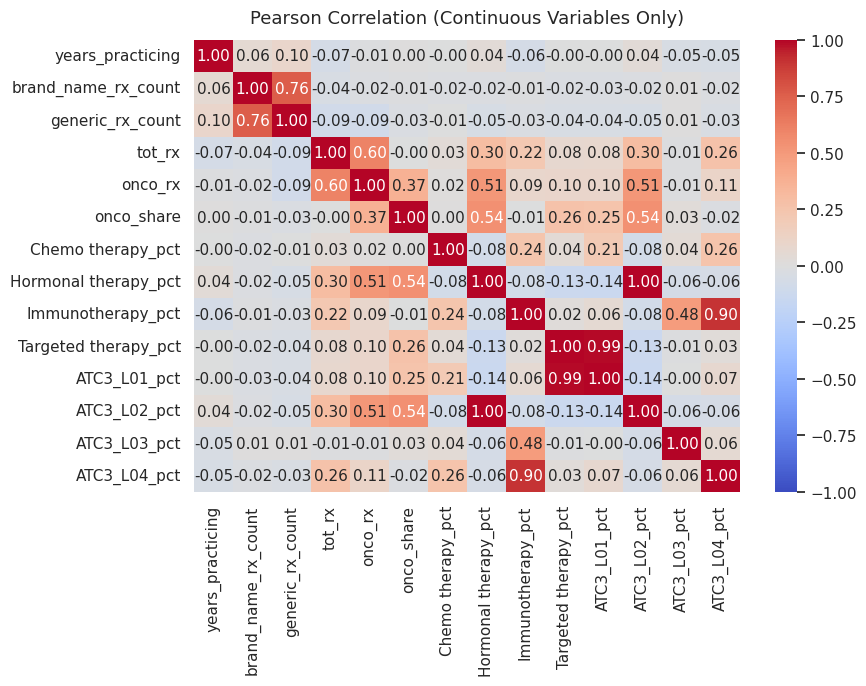

In [20]:
# [Step 7-1] final_df_with_y 기준 연속형 변수 상관분석(식별자·y 계열 제외) 및 히트맵 시각화

# cluster를 명목형으로 전환
final_df_with_y['cluster'] = final_df_with_y['cluster'].astype('category')

# =========================================
# 연속형 변수만 상관분석 & 시각화
# 기준: final_df_with_y
# =========================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) 연속형 변수만 선택
num_cols = final_df_with_y.select_dtypes(include=['int32','int64','float64']).columns.tolist()

# npi(식별자) 제거
if 'npi' in num_cols:
    num_cols.remove('npi')

# 완전 이진(0/1) 변수 자동 제외
bin_cols = []
for c in num_cols:
    vals = final_df_with_y[c].dropna().unique()
    if len(vals) <= 2 and set(np.unique(vals)).issubset({0,1}):
        bin_cols.append(c)

cont_cols = [c for c in num_cols if c not in bin_cols]

#종속변수 제거
exclude_cols = [c for c in final_df_with_y.columns if c.startswith('y_')]
cont_cols = [c for c in cont_cols if c not in exclude_cols]

# 2) 피어슨 상관계수 행렬
corr = final_df_with_y[cont_cols].corr(method='pearson')

import seaborn as sns

plt.figure(figsize=(max(9, 0.5*len(cont_cols)), max(7, 0.5*len(cont_cols))))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Pearson Correlation (Continuous Variables Only)', pad=12)
plt.tight_layout()
plt.show()


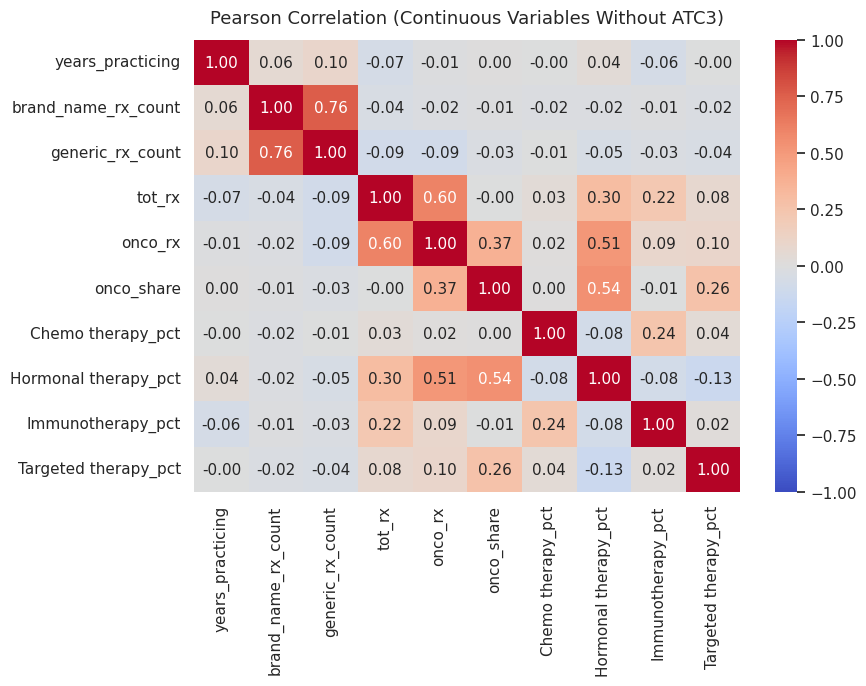

In [21]:
# [Step 7-2] ATC3 기반 변수 제거(다중공선성 완화) 후 상관분석 재실행 → final_df_with_y_woatc 생성

#ATC4 level로 onco sub category를 만들었기 때문에 공선성 발생 -> atc 보다 sub category가 더 설명을 잘 하기 때문에 atc3 level 변수 제외

# 기존 cont_cols에서 ATC3_ 포함된 컬럼 제거
cont_cols_woatc = [c for c in cont_cols if not c.startswith('ATC3_')]

# final_df_with_y 전체에서 ATC3 컬럼만 제거
final_df_with_y_woatc = final_df_with_y.drop(columns=[c for c in final_df_with_y.columns
                                                      if c.startswith("ATC3_")])

# 피어슨 상관계수 행렬
corr_v1 = final_df_with_y_woatc[cont_cols_woatc].corr(method='pearson')

# 히트맵 시각화
import seaborn as sns
plt.figure(figsize=(max(9, 0.5*len(cont_cols_woatc)), max(7, 0.5*len(cont_cols_woatc))))
sns.heatmap(corr_v1, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Pearson Correlation (Continuous Variables Without ATC3)', pad=12)
plt.tight_layout()
plt.show()


In [26]:
# [Step 7-3] 항암 처방 여부(y_L3_has_onco) 기준 카이제곱(범주형) + ANOVA(연속형) 통합 검정 테이블 생성

import pandas as pd
import numpy as np
from scipy import stats

# =======================================
# 0) 데이터 준비
# =======================================
df = final_df_with_y_woatc.copy()

dep = 'y_L3_has_onco'   # 공통 종속변수 (항암제 처방 여부: 0/1)

# 범주형 독립변수 (카이제곱용)
cat_cols = ['specialty', 'region', 'gender', 'settlement_type', 'cluster']

# 연속형 독립변수 (ANOVA용)
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
num_cols = [c for c in num_cols if not c.startswith('y_') and c != 'npi']

# y_L3_has_onco 이진 여부 확인
assert df[dep].nunique() == 2, "y_L3_has_onco가 0/1 이진 변수가 아닙니다."

group_vals = sorted(df[dep].dropna().unique())  # 예: [0, 1]

summary_rows = []

# =======================================
# 1) Chi-square (범주형 vs 항암제 여부)
# =======================================
for x in cat_cols:
    try:
        tab = pd.crosstab(df[x], df[dep])
        if tab.shape[0] > 1 and tab.shape[1] > 1:
            chi2, p, dof, ex = stats.chi2_contingency(tab)
            summary_rows.append({
                "Variable": x,
                "Variable type": "categorical",
                "Test": "Chi-square",
                "mean_0": np.nan,
                "mean_1": np.nan,
                "Statistic": round(chi2, 4),
                "p_value": p
            })
        else:
            summary_rows.append({
                "Variable": x,
                "Variable type": "categorical",
                "Test": "Chi-square",
                "mean_0": np.nan,
                "mean_1": np.nan,
                "Statistic": np.nan,
                "p_value": np.nan
            })
    except Exception:
        summary_rows.append({
            "Variable": x,
            "Variable type": "categorical",
            "Test": "Chi-square",
            "mean_0": np.nan,
            "mean_1": np.nan,
            "Statistic": np.nan,
            "p_value": np.nan
        })

# =======================================
# 2) ANOVA (연속형 vs 항암제 여부)
# =======================================
for x in num_cols:
    g0 = df.loc[df[dep] == group_vals[0], x].dropna()
    g1 = df.loc[df[dep] == group_vals[1], x].dropna()

    if len(g0) > 1 and len(g1) > 1:
        f, p = stats.f_oneway(g0, g1)
        summary_rows.append({
            "Variable": x,
            "Variable type": "continuous",
            "Test": "ANOVA",
            "mean_0": round(g0.mean(), 3),
            "mean_1": round(g1.mean(), 3),
            "Statistic": round(f, 4),
            "p_value": p
        })

# =======================================
# 3) 표 정리 + p-value 포맷 + 유의성 표시
# =======================================
summary_df = pd.DataFrame(summary_rows)

# Sig 컬럼 추가
def sig_marker(p):
    if pd.isna(p):
        return ""
    return "***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else ""

summary_df["Sig"] = summary_df["p_value"].apply(sig_marker)

# 표시용 p-value 문자열
summary_df["p_value_disp"] = summary_df["p_value"].apply(
    lambda p: f"{p:.6f}" if pd.notna(p) else "NaN"
)

# 정렬: 유의한 것 위로, 그 안에서 p-value 오름차순
summary_df = summary_df.sort_values(
    by=["Test", "p_value"],
    key=lambda col: col.where(col.notna(), 1.0)
).reset_index(drop=True)

# 최종 표시 컬럼 선택
display(summary_df[[
    "Test",
    "Variable type",
    "Variable",
    "mean_0",
    "mean_1",
    "Statistic",
    "p_value_disp",
    "Sig"
]])


,Test,Variable type,Variable,mean_0,mean_1,Statistic,p_value_disp,Sig
0,ANOVA,continuous,Hormonal therapy_pct,0.000,67.649,674.9186,0.000000,***
1,ANOVA,continuous,onco_share,0.000,0.317,268.2911,0.000000,***
2,ANOVA,continuous,onco_rx,0.000,202.634,172.5246,0.000000,***
3,ANOVA,continuous,Targeted therapy_pct,0.000,24.007,109.8759,0.000000,***
4,ANOVA,continuous,tot_rx,129.297,915.678,71.9830,0.000000,***
5,ANOVA,continuous,Immunotherapy_pct,0.000,7.311,30.6165,0.000000,***
6,ANOVA,continuous,Chemo therapy_pct,0.000,1.033,5.9491,0.015110,*
7,ANOVA,continuous,generic_rx_count,562.715,434.119,2.5561,0.110569,
8,ANOVA,continuous,brand_name_rx_count,78.070,65.034,0.5411,0.462340,
9,ANOVA,continuous,years_practicing,6.943,6.966,0.0633,0.801517,


In [27]:
# [Step 7-4] Level 1 회귀분석: y_L1_tot_rx(로그 변환) 회귀용 X 구성 및 OLS 적합/평가(회귀 접근 타당성 점검)

# ============================================
# Level 1 (누수 방지 + 원핫인코딩)
# --------------------------------------------
# - 입력 데이터: final_df_with_y_woatc (네가 이미 만든 최종 테이블)
# - Level 1 (활동규모):      y_L1_tot_rx  (연속형)  → tot_rx/onco_rx/onco_share 제외
# - 범주형 설명변수: specialty, region, gender, settlement_type, cluster → 원핫(drop_first=True)
# ============================================

import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# 0) 원본에서 복사본 생성 (원본 안전 보존)
df = final_df_with_y_woatc.copy()

# 1) 식별자/타깃 prefix 등 공통 제외 규칙 정의
id_cols = {'npi'}                              # 식별자
y_prefix = 'y_'                                # 종속변수 접두어

# 2) 회귀 설계용 범주형 열 지정 (원핫 대상)
cat_cols = ['specialty','region','gender','settlement_type','cluster']

# 3) 공통: 설계행렬 X, 타깃 y를 만드는 함수
def build_Xy_for_linear(df, y_col, leakage_exclude=None):
    """
    df: 전체 데이터프레임
    y_col: 이번 모델의 타깃 열 이름 (연속형)
    leakage_exclude: 이번 모델에서 누수 방지를 위해 반드시 제외할 열 set
    """
    if leakage_exclude is None:
        leakage_exclude = set()

    # 3-1) 타깃 y 추출 (연속형으로 캐스팅)
    y = df[y_col].astype(float)

    # 3-2) 더미 인코딩: 지정한 범주형만 원핫, drop_first=True로 기준범주 제거(완전 공선성 방지)
    X_cat = pd.get_dummies(df[cat_cols], drop_first=True).astype('float64')

    # 3-3) 수치형 후보 추출: int/float만 선택
    num_cols = df.select_dtypes(include=['int32','int64','float64']).columns.tolist()

    # 3-4) 수치형에서 (식별자/모든 y_계열/이번 타깃/누수 제외 컬럼) 제거
    exclude_cols = set(c for c in df.columns if c.startswith(y_prefix)) | id_cols | {y_col} | leakage_exclude
    num_cols = [c for c in num_cols if c not in exclude_cols]

    # 3-5) 수치형 설명변수 부분프레임 구성
    X_num = df[num_cols].copy()

    # 3-6) 수치형 + 더미 결합
    X = pd.concat([X_num, X_cat], axis=1)

    # 3-7) 결측/무한대 방지: 무한대는 NaN으로 바꾸고, 남은 NaN은 0으로 대체(선형회귀 수치 안정화)
    X = X.replace([np.inf, -np.inf], np.nan).fillna(0)

    # 3-8) 상수항 추가
    X = sm.add_constant(X, has_constant='add')

    return X, y

# 4) 공통: 학습/평가 함수 (train/test split + OLS 적합 + 기본 지표)
def fit_and_eval_linear(X, y, test_size=0.2, random_state=42, logy=False):
    """
    logy=True면 타깃을 log1p로 변환해 학습(오른쪽 꼬리 완화), 평가 시 역변환 후 RMSE/MAE/R2 계산
    """
    # 4-1) 타깃 로그 변환 여부 적용
    y_use = np.log1p(y.clip(lower=0)) if logy else y.copy()

    # 4-2) 학습/검증 분할
    X_tr, X_te, y_tr, y_te = train_test_split(X, y_use, test_size=test_size, random_state=random_state)

    # 4-3) OLS 적합
    model = sm.OLS(y_tr, X_tr).fit()

    # 4-4) 예측
    pred = model.predict(X_te)

    # 4-5) 역변환 필요 시(로그 변환) 역변환 후 지표 계산
    if logy:
        y_true = np.expm1(y_te)
        y_pred = np.expm1(pred)
    else:
        y_true = y_te
        y_pred = pred

    # 4-6) 성능지표 계산
    metrics = {
        'R2': r2_score(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred)
    }

    return model, metrics

# 5) 보조: 계수 상/하위 정렬해서 보기 좋게 출력
def show_top_coefs(model, k=15):
    params = model.params.drop('const', errors='ignore')
    top_pos = params.sort_values(ascending=False).head(k).rename('coef_top+')
    top_neg = params.sort_values(ascending=True).head(k).rename('coef_top-')
    return pd.concat([top_pos, top_neg], axis=1)

# ============================================
# Level 1: y_L1_tot_rx (활동규모) — 선형회귀
#  - 누수 위험: tot_rx(동일개념), onco_rx(부분합), onco_share(직접비율)
#  - 공선성 문제가 아니라 "논리적 중복/누수"라서 제외 권장
# ============================================
y_lvl1 = 'y_L1_tot_rx'
leak_lvl1 = {'tot_rx', 'onco_rx', 'onco_share'}  # 필요하면 조정 가능

# 6) X, y 생성 (누수 제외 반영)
X1, y1 = build_Xy_for_linear(df, y_lvl1, leakage_exclude=leak_lvl1)

# 7) 모델 적합/평가: 원스케일 / 로그스케일 모두 확인(분포에 따라 선택)
m1_lin, m1_lin_mx = fit_and_eval_linear(X1, y1, logy=False)
m1_log, m1_log_mx = fit_and_eval_linear(X1, y1, logy=True)

print("=== [Level 1: y_L1_tot_rx] Linear Metrics ===")
print(m1_lin_mx)
print("\n[Level 1] Linear Summary")
print(m1_lin.summary())

print("\n=== [Level 1: y_L1_tot_rx] Log1p(Target) Linear Metrics ===")
print(m1_log_mx)
print("\n[Level 1] Log1p(Target) Linear Summary")
print(m1_log.summary())

print("\n[Level 1] Top coefficients (Linear)")
display(show_top_coefs(m1_lin, k=15))


=== [Level 1: y_L1_tot_rx] Linear Metrics ===
{'R2': 0.4261451534399442, 'RMSE': np.float64(1.090676679978232), 'MAE': 0.8366983567764855}

[Level 1] Linear Summary
                            OLS Regression Results                            
Dep. Variable:            y_L1_tot_rx   R-squared:                       0.641
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     25.12
Date:                Tue, 09 Dec 2025   Prob (F-statistic):           7.80e-61
Time:                        08:23:25   Log-Likelihood:                -509.63
No. Observations:                 362   AIC:                             1069.
Df Residuals:                     337   BIC:                             1167.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                             

,coef_top+,coef_top-
specialty_Pediatric Hematology-Oncology,0.643269,NaN
specialty_Oncology,0.308120,NaN
region_South,0.207819,NaN
settlement_type_urban,0.061546,NaN
gender_M,0.031543,NaN
Chemo therapy_pct,0.022825,NaN
Immunotherapy_pct,0.020855,NaN
Hormonal therapy_pct,0.020223,NaN
Targeted therapy_pct,0.015901,NaN
years_practicing,0.008037,0.008037


In [28]:
# [Step 8-0] 분류모델 공통 준비: 설명변수(X)·타깃(y_onco) 설정, OneHot 포함 ColumnTransformer 정의 및 train/test 분리

# ============================================================
# [공통 준비] 라이브러리 import + 컬럼 설정 + 전처리기 정의
# ============================================================

# 1) 라이브러리 불러오기
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    confusion_matrix
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# 2) Cytotoxic → Chemo 라벨 이름 통일
#    - 기존: y_L4_Cytotoxic_agents_bin
#    - 변경: y_L4_Chemo_therapy_bin
#    - 이렇게 해두면 나중에 label_cols에서 이름이 깔끔해짐
df = df.rename(columns={
    "y_L4_Cytotoxic_agents_bin": "y_L4_Chemo_therapy_bin"
})

# 3) 범주형 / 수치형 피처 컬럼 정의
#    - cat_cols : One-Hot 인코딩할 범주형 변수들
#    - num_cols : 그대로 쓸 수치형 변수들
cat_cols = ["specialty", "region", "gender", "settlement_type", "cluster"]
num_cols = ["years_practicing", "brand_name_rx_count", "generic_rx_count"]

# 4) X(설명변수) 정의
#    - 나중에 모든 모델에서 공통으로 사용할 입력 데이터
X = df[cat_cols + num_cols].copy()

# 5) 전처리기(ColumnTransformer) 정의
#    - 범주형(cat_cols): OneHotEncoder(drop="first", handle_unknown="ignore")
#      · drop="first"        : 기준 범주 하나 제거 → 완전 공선성 방지
#      · handle_unknown="ignore" : train에 없던 카테고리가 test에 나와도 에러 없이 0으로 처리
#    - 수치형(num_cols): "passthrough"로 그대로 사용
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols),
    ]
)

# 6) 전처리기를 X 전체 데이터로 한 번만 fit
#    - 이렇게 해두면 이후에는 train/test를 어떻게 나눠도
#      같은 인코딩 규칙을 사용하게 됨
preprocess.fit(X)

# 1) 타깃 변수 y_onco 만들기
#    - onco_rx(항암 처방량)가 0보다 크면 1, 아니면 0으로 이진화
df["y_onco"] = (df["onco_rx"] > 0).astype(int)

# 2) y(타깃) 정의
y_onco = df["y_onco"].copy()

# 3) Train / Test 데이터 나누기
#    - test_size=0.2 : 20%는 테스트, 80%는 학습
#    - stratify=y_onco : 항암 여부(0/1) 비율을 train/test에서 비슷하게 유지
X_train, X_test, y_train, y_test = train_test_split(
    X,               # 공통 입력 피처
    y_onco,          # 항암 여부 타깃
    test_size=0.2,
    random_state=42,
    stratify=y_onco
)

# 4) 전처리기(preprocess)를 사용해서 숫자 행렬로 변환
#    - preprocess는 이미 X 전체로 fit 되어 있음 (공통 준비 코드에서)
#    - 여기서는 transform만 수행
X_train_tr = preprocess.transform(X_train)
X_test_tr  = preprocess.transform(X_test)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



===== Logistic Regression (y_onco) =====
Accuracy : 0.8791208791208791
F1-score : 0.907563025210084
ROC-AUC  : 0.8972457627118644
Confusion Matrix:
 [[26  6]
 [ 5 54]]

===== RandomForest (y_onco) =====
Accuracy : 0.8461538461538461
F1-score : 0.8852459016393442
ROC-AUC  : 0.8720868644067798
Confusion Matrix:
 [[23  9]
 [ 5 54]]

===== RandomForest Feature Importance (상위 20개) =====


,feature,importance
14,cat__cluster_3,0.200245
19,num__generic_rx_count,0.154944
12,cat__cluster_1,0.114043
18,num__brand_name_rx_count,0.111647
16,cat__cluster_5,0.069601
15,cat__cluster_4,0.061174
17,num__years_practicing,0.060573
13,cat__cluster_2,0.057821
11,cat__settlement_type_urban,0.029215
10,cat__gender_M,0.027037


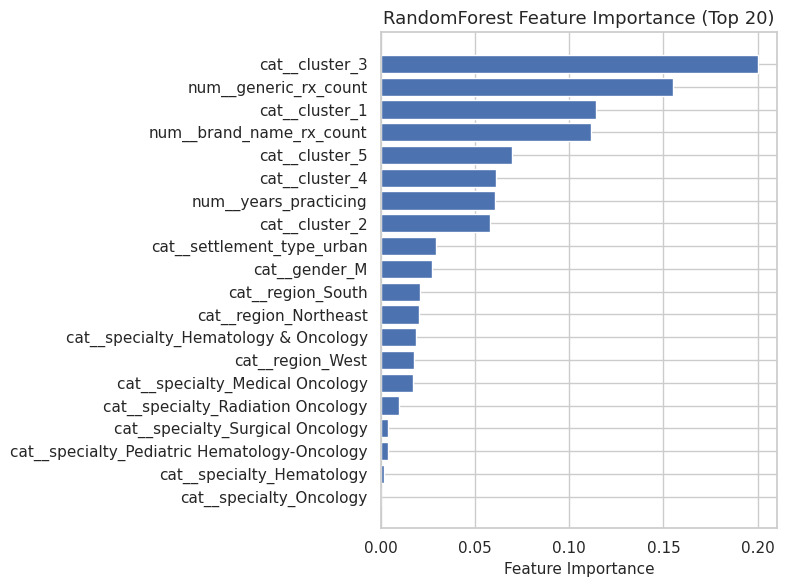


===== Logistic Regression 계수 및 오즈비 (상위 20개) =====


,feature,coef,odds_ratio,abs_coef
14,cat__cluster_3,-3.328875,0.035833,3.328875
12,cat__cluster_1,-2.779196,0.062088,2.779196
13,cat__cluster_2,-2.600105,0.074266,2.600105
16,cat__cluster_5,-2.249815,0.105419,2.249815
15,cat__cluster_4,1.982076,7.257794,1.982076
4,cat__specialty_Pediatric Hematology-Oncology,0.653803,1.922839,0.653803
10,cat__gender_M,0.645386,1.906723,0.645386
11,cat__settlement_type_urban,-0.389793,0.677197,0.389793
7,cat__region_Northeast,-0.282900,0.753595,0.282900
5,cat__specialty_Radiation Oncology,-0.265440,0.766869,0.265440


In [32]:
# [Step 8-1] 항암 처방 여부 예측: Logistic Regression + RandomForest 학습/평가 및 RF 중요도·Logistic 오즈비 테이블 생성

# ============================================================
# A. 항암 처방 여부 예측 (y_onco) - Logistic regression + RandomForest
# ============================================================

# 5) 모델 1: 로지스틱 회귀 정의
#    - max_iter=200 : 경사하강 반복 횟수를 넉넉히 줘서 수렴 보장
logreg = LogisticRegression(max_iter=200)

# 6) 로지스틱 회귀 학습
logreg.fit(X_train_tr, y_train)

# 7) 로지스틱 회귀 예측
#    - pred_logreg : 0/1 클래스 예측값
#    - proba_logreg : 1(항암 처방 있음)일 확률
pred_logreg = logreg.predict(X_test_tr)
proba_logreg = logreg.predict_proba(X_test_tr)[:, 1]

# 8) 모델 2: 랜덤포레스트 분류기 정의
#    - n_estimators=300 : 트리 300개 사용 (조금 더 안정적)
#    - random_state=42  : 랜덤 고정 (재현성 확보)
rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42
)

# 9) 랜덤포레스트 학습
rf.fit(X_train_tr, y_train)

# 10) 랜덤포레스트 예측
#     - pred_rf  : 0/1 클래스 예측값
#     - proba_rf : 1(항암 처방 있음)일 확률
pred_rf = rf.predict(X_test_tr)
proba_rf = rf.predict_proba(X_test_tr)[:, 1]

# 11) 성능 출력용 함수 정의
#     - 모델 이름, 실제값, 예측값, 확률을 넣으면
#       Accuracy, F1-score, ROC-AUC, Confusion Matrix를 출력
def evaluate_model(name, y_true, pred, proba):
    print(f"\n===== {name} =====")
    print("Accuracy :", accuracy_score(y_true, pred))
    print("F1-score :", f1_score(y_true, pred))
    print("ROC-AUC  :", roc_auc_score(y_true, proba))
    print("Confusion Matrix:\n", confusion_matrix(y_true, pred))

# 12) 두 모델 성능 비교 출력
evaluate_model("Logistic Regression (y_onco)", y_test, pred_logreg, proba_logreg)
evaluate_model("RandomForest (y_onco)",       y_test, pred_rf,      proba_rf)

# ============================================================
# 15) RandomForest 변수 중요도 시각화 (상위 20개)
#      - preprocess에서 가져온 feature_names 재사용
# ============================================================

# 15-1) feature importance 추출
rf_importances = rf.feature_importances_

rf_imp_df = pd.DataFrame({
    "feature": feature_names,
    "importance": rf_importances
}).sort_values("importance", ascending=False)

print("\n===== RandomForest Feature Importance (상위 20개) =====")
display(rf_imp_df.head(20))

# 15-2) 상위 20개 바 차트 그리기
top_n = 20
rf_top = rf_imp_df.head(top_n).iloc[::-1]  # 그래프에서 위가 큰 값 되도록 역순

plt.figure(figsize=(8, 6))
plt.barh(rf_top["feature"], rf_top["importance"])
plt.xlabel("Feature Importance")
plt.title(f"RandomForest Feature Importance (Top {top_n})")
plt.tight_layout()
plt.show()

# ============================================================
# 13) 로지스틱 회귀 계수 + 오즈비(odds ratio) 테이블 만들기
#    - 전처리된 피처 이름 + 계수 + 오즈비를 한 번에 확인
#    - 계수는 log-odds, exp(coef) = 오즈비
# ============================================================

# 13-1) 전처리 후 피처 이름 가져오기
#       ColumnTransformer(preprocess)에 get_feature_names_out() 있으면 그걸 쓰고,
#       없으면 그냥 순번 기반 이름으로 대체
try:
    feature_names = preprocess.get_feature_names_out()
except:
    feature_names = [f"feat_{i}" for i in range(X_train_tr.shape[1])]

# 13-2) 로지스틱 회귀 계수 가져오기
#       logreg.coef_ shape = (1, n_features) 이라서 ravel()로 1차원으로 펼침
coefs = logreg.coef_.ravel()

# 13-3) 오즈비(odds ratio) = exp(coef)
odds_ratios = np.exp(coefs)

# 13-4) DataFrame으로 정리
logit_coef_df = pd.DataFrame({
    "feature": feature_names,
    "coef": coefs,
    "odds_ratio": odds_ratios
})

# 13-5) 절대값 기준으로 중요도 큰 순서대로 정렬 (|coef| 큰 변수일수록 영향력 큼)
logit_coef_df["abs_coef"] = logit_coef_df["coef"].abs()
logit_coef_df_sorted = logit_coef_df.sort_values("abs_coef", ascending=False)

print("\n===== Logistic Regression 계수 및 오즈비 (상위 20개) =====")
display(logit_coef_df_sorted.head(20))


In [30]:
# [Step 8-2] XGBoost·LightGBM 학습/평가 (클래스 불균형 보정 포함) → 기존 모델과 성능 비교용

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# 클래스 비율 확인 (0: 항암 처방 없음, 1: 있음)
class_counts = y_train.value_counts()
neg = class_counts[0]
pos = class_counts[1]
pos_weight = neg / pos
print("class_counts:", class_counts.to_dict(), " → pos_weight =", pos_weight)

# ==========================
# XGBoost 모델 학습 + 평가
# ==========================

xgb_model = XGBClassifier(
    n_estimators=300,        # 트리 개수
    learning_rate=0.1,      # 학습률
    max_depth=3,            # 트리 깊이 (데이터 작으니까 과적합 방지)
    subsample=0.9,
    colsample_bytree=0.9,
    eval_metric="logloss",  # XGBoost용 필수 설정
    scale_pos_weight=pos_weight,  # 클래스 불균형 보정
    random_state=42,
    n_jobs=-1
)

# 학습
xgb_model.fit(X_train_tr, y_train)

# 예측 (클래스 + 확률)
pred_xgb = xgb_model.predict(X_test_tr)
proba_xgb = xgb_model.predict_proba(X_test_tr)[:, 1]

# 기존 evaluate_model 함수 재사용
evaluate_model("XGBoost (y_onco)", y_test, pred_xgb, proba_xgb)

# ==========================
# LightGBM 모델 학습 + 평가
# ==========================

lgbm_model = LGBMClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=-1,           # -1이면 자동 (필요하면 3~5로 제한해도 됨)
    subsample=0.9,
    colsample_bytree=0.9,
    class_weight="balanced",  # 불균형 자동 보정
    random_state=42,
    n_jobs=-1
)

# 학습
lgbm_model.fit(X_train_tr, y_train)

# 예측 (클래스 + 확률)
pred_lgbm = lgbm_model.predict(X_test_tr)
proba_lgbm = lgbm_model.predict_proba(X_test_tr)[:, 1]

# 성능 출력
evaluate_model("LightGBM (y_onco)", y_test, pred_lgbm, proba_lgbm)


class_counts: {1: 236, 0: 126}  → pos_weight = 0.5338983050847458

===== XGBoost (y_onco) =====
Accuracy : 0.8351648351648352
F1-score : 0.8672566371681416
ROC-AUC  : 0.8776483050847457
Confusion Matrix:
 [[27  5]
 [10 49]]
[LightGBM] [Info] Number of positive: 236, number of negative: 126
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002701 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 215
[LightGBM] [Info] Number of data points in the train set: 362, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


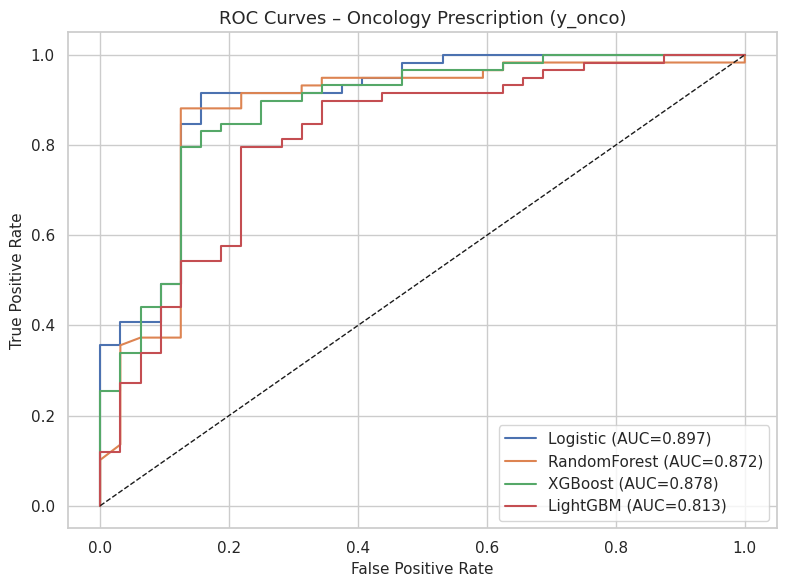

In [33]:
# [Step 8-3] 4개 모델(Logistic/RF/XGBoost/LightGBM) ROC Curve 한 장에 시각화

# ============================================================
# 14) 4개 모델 ROC Curve 한 장에 그리기
#      - Logistic / RandomForest / XGBoost / LightGBM
#      - proba_xgb, proba_lgbm 은 앞에서 이미 계산되었다고 가정
# ============================================================
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

# 1) Logistic Regression
fpr_log, tpr_log, _ = roc_curve(y_test, proba_logreg)
auc_log = auc(fpr_log, tpr_log)
plt.plot(fpr_log, tpr_log, label=f"Logistic (AUC={auc_log:.3f})")

# 2) RandomForest
fpr_rf, tpr_rf, _ = roc_curve(y_test, proba_rf)
auc_rf = auc(fpr_rf, tpr_rf)
plt.plot(fpr_rf, tpr_rf, label=f"RandomForest (AUC={auc_rf:.3f})")

# 3) XGBoost (있으면 사용)
try:
    fpr_xgb, tpr_xgb, _ = roc_curve(y_test, proba_xgb)
    auc_xgb = auc(fpr_xgb, tpr_xgb)
    plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC={auc_xgb:.3f})")
except NameError:
    print("[주의] proba_xgb 변수가 없어 XGBoost ROC는 생략되었습니다.")

# 4) LightGBM (있으면 사용)
try:
    fpr_lgb, tpr_lgb, _ = roc_curve(y_test, proba_lgbm)
    auc_lgb = auc(fpr_lgb, tpr_lgb)
    plt.plot(fpr_lgb, tpr_lgb, label=f"LightGBM (AUC={auc_lgb:.3f})")
except NameError:
    print("[주의] proba_lgbm 변수가 없어 LightGBM ROC는 생략되었습니다.")

# 기준선 (무작위 모델)
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves – Oncology Prescription (y_onco)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

X_train_dl shape: (362, 20)
X_test_dl  shape: (91, 20)
class_weight (for Keras): {0: 1.4365079365079365, 1: 0.7669491525423728}


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,457 (13.50 KB)

 Trainable params: 3,457 (13.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.5272 - auc: 0.5442 - loss: 26.1173 - val_accuracy: 0.3699 - val_auc: 0.5175 - val_loss: 5.4012
Epoch 2/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.4369 - auc: 0.4048 - loss: 28.8774 - val_accuracy: 0.3562 - val_auc: 0.6100 - val_loss: 15.9266
Epoch 3/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4891 - auc: 0.5211 - loss: 26.6549 - val_accuracy: 0.3562 - val_auc: 0.6104 - val_loss: 15.3456
Epoch 4/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4314 - auc: 0.4520 - loss: 27.0210 - val_accuracy: 0.3425 - val_auc: 0.5675 - val_loss: 11.2077
Epoch 5/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.4380 - auc: 0.4622 - loss: 20.2749 - val_accuracy: 0.3562 - val_auc: 0.5396 - val_loss: 5.5269
Epoch 6/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.5115 - auc: 0.5321 - loss: 17.1079 - val_accuracy: 0.3562 - val_auc: 0.5458 - val_loss: 9.9337
Epoch 7/200
10/10 ━━━━━━━━━━━━━

,threshold,precision,recall,f1,specificity,tn,fp,fn,tp
0,0.30,0.647059,0.932203,0.763889,0.06250,2,30,4,55
1,0.35,0.654762,0.932203,0.769231,0.09375,3,29,4,55
2,0.40,0.646341,0.898305,0.751773,0.09375,3,29,6,53
3,0.45,0.637500,0.864407,0.733813,0.09375,3,29,8,51
4,0.50,0.640000,0.813559,0.716418,0.15625,5,27,11,48
5,0.55,0.600000,0.508475,0.550459,0.37500,12,20,29,30
6,0.60,0.615385,0.406780,0.489796,0.53125,17,15,35,24
7,0.65,0.558824,0.322034,0.408602,0.53125,17,15,40,19
8,0.70,0.500000,0.220339,0.305882,0.59375,19,13,46,13
9,0.75,0.529412,0.152542,0.236842,0.75000,24,8,50,9


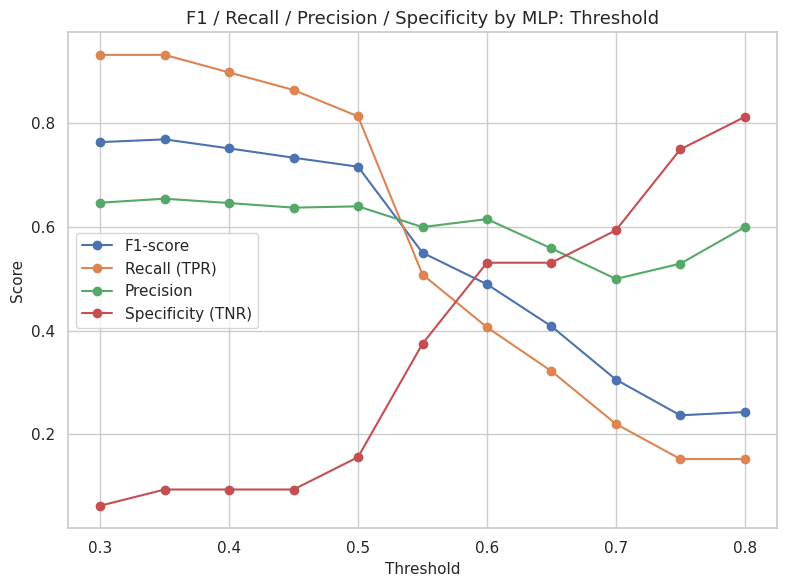

In [34]:
# [Step 9-1] 딥러닝(MLP) 모델 구성·학습·Threshold별 지표 계산: Tabular용 MLP + class_weight + EarlyStopping

 ============================================================
# [딥러닝 모델: MLP (Tabular용)] - TensorFlow Keras 사용
#  - 입력: 전처리된 X_train_tr, X_test_tr (ColumnTransformer 결과)
#  - 타깃: y_train, y_test (0/1, 항암 처방 여부)
# ============================================================

import numpy as np
import scipy.sparse as sp

# ▼ 추가된 부분: precision_score, recall_score 꼭 import!
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    precision_score,
    recall_score
)
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# -------------------------------------------------------------------
# 1) Sparse → Dense 변환 (ColumnTransformer 결과가 sparse일 수 있음)
# -------------------------------------------------------------------
def to_dense(X):
    """
    전처리 결과 X가 sparse matrix이면 .toarray()로 dense로 변환하고,
    이미 numpy array면 그대로 반환.
    """
    if sp.issparse(X):
        return X.toarray()
    else:
        return X

X_train_dl = to_dense(X_train_tr)
X_test_dl  = to_dense(X_test_tr)

print("X_train_dl shape:", X_train_dl.shape)
print("X_test_dl  shape:", X_test_dl.shape)

# -------------------------------------------------------------------
# 2) 클래스 불균형에 따른 class_weight 계산
# -------------------------------------------------------------------
classes = np.unique(y_train)  # [0, 1]
class_weights_values = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_train
)

class_weight = {int(c): float(w) for c, w in zip(classes, class_weights_values)}
print("class_weight (for Keras):", class_weight)

# -------------------------------------------------------------------
# 3) MLP 모델 정의
# -------------------------------------------------------------------
input_dim = X_train_dl.shape[1]

mlp_model = keras.Sequential([
    layers.Input(shape=(input_dim,)),  # 입력층
    layers.Dense(
        64, activation="relu",
        kernel_regularizer=keras.regularizers.l2(1e-4)
    ),
    layers.Dropout(0.3),
    layers.Dense(
        32, activation="relu",
        kernel_regularizer=keras.regularizers.l2(1e-4)
    ),
    layers.Dropout(0.3),
    layers.Dense(1, activation="sigmoid")  # 이진분류 출력층
])

# -------------------------------------------------------------------
# 4) 모델 컴파일
# -------------------------------------------------------------------
mlp_model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    metrics=[
        "accuracy",
        keras.metrics.AUC(name="auc")
    ]
)

mlp_model.summary()

# -------------------------------------------------------------------
# 5) EarlyStopping 콜백
# -------------------------------------------------------------------
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=20,
    restore_best_weights=True,
    verbose=1
)

# -------------------------------------------------------------------
# 6) 모델 학습
# -------------------------------------------------------------------
history = mlp_model.fit(
    X_train_dl,
    y_train.values if hasattr(y_train, "values") else y_train,
    epochs=200,
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weight,
    callbacks=[early_stop],
    verbose=1
)

# -------------------------------------------------------------------
# 7) 테스트셋 평가 (기존 evaluate_model 재사용)
# -------------------------------------------------------------------
proba_mlp = mlp_model.predict(X_test_dl).ravel()
pred_mlp  = (proba_mlp >= 0.5).astype(int)

evaluate_model("MLP Deep Learning (y_onco)", y_test, pred_mlp, proba_mlp)

# -------------------------------------------------------------------
# 8) Threshold 스윕 (F1 / Recall / Precision / Specificity)
# -------------------------------------------------------------------
import pandas as pd
import matplotlib.pyplot as plt

thresholds = np.arange(0.30, 0.85, 0.05)
thresholds = np.round(thresholds, 2)

mlp_metric_rows = []

for thr in thresholds:
    y_pred_thr = (proba_mlp >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_thr).ravel()

    prec = precision_score(y_test, y_pred_thr, zero_division=0)
    rec  = recall_score(y_test, y_pred_thr, zero_division=0)
    f1   = f1_score(y_test, y_pred_thr, zero_division=0)
    spec = tn / (tn + fp) if (tn + fp) > 0 else np.nan

    mlp_metric_rows.append({
        "threshold": thr,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "specificity": spec,
        "tn": tn,
        "fp": fp,
        "fn": fn,
        "tp": tp,
    })

mlp_metrics_df = pd.DataFrame(mlp_metric_rows)
print("\n=== [MLP Deep Learning] Threshold별 지표 ===")
display(mlp_metrics_df)

plt.figure(figsize=(8, 6))
plt.plot(mlp_metrics_df["threshold"], mlp_metrics_df["f1"],         marker="o", label="F1-score")
plt.plot(mlp_metrics_df["threshold"], mlp_metrics_df["recall"],     marker="o", label="Recall (TPR)")
plt.plot(mlp_metrics_df["threshold"], mlp_metrics_df["precision"],  marker="o", label="Precision")
plt.plot(mlp_metrics_df["threshold"], mlp_metrics_df["specificity"],marker="o", label="Specificity (TNR)")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("F1 / Recall / Precision / Specificity by MLP: Threshold")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


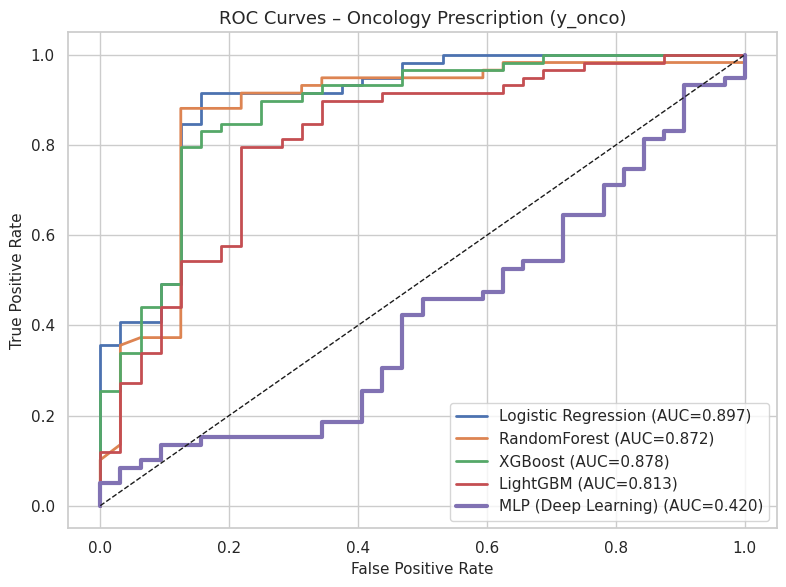

In [35]:
# [Step 9-2] 최종 ROC Curve: Logistic/RF/XGBoost/LightGBM/MLP 5개 모델 ROC 한 장 비교(MLP 라인 강조)

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# ============================================================
# 최종 ROC Curve: 5개 모델 (LogReg / RF / XGBoost / LGBM / MLP)
#  - MLP 라인은 더 두껍게 해서 하이라이트
# ============================================================

plt.figure(figsize=(8, 6))

model_probas = {
    "Logistic Regression": proba_logreg,
    "RandomForest":        proba_rf,
    "XGBoost":             proba_xgb,
    "LightGBM":            proba_lgbm,
    "MLP (Deep Learning)": proba_mlp,
}

for name, proba in model_probas.items():
    fpr, tpr, _ = roc_curve(y_test, proba)
    roc_auc = auc(fpr, tpr)

    # MLP는 더 두껍게 강조
    if "MLP" in name:
        plt.plot(
            fpr, tpr,
            label=f"{name} (AUC={roc_auc:.3f})",
            linewidth=3
        )
    else:
        plt.plot(
            fpr, tpr,
            label=f"{name} (AUC={roc_auc:.3f})",
            linewidth=2
        )

# 랜덤 분류 기준선
plt.plot([0, 1], [0, 1], "k--", linewidth=1)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves – Oncology Prescription (y_onco)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()

# 슬라이드에 넣을 이미지로 저장 (원하면 경로/파일명 바꿔도 됨)
plt.savefig("roc_all_models_with_mlp.png", dpi=300)
plt.show()
